In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,39412,None,None,85798.971570
2020-06-13,39413,None,None,79712.080922
2020-06-14,39414,None,None,74058.149895
2020-06-15,39415,None,None,68732.777661
2020-06-16,39416,None,None,63989.507037
...,...,...,...,...
2021-03-14,39687,None,None,92764.201797
2021-03-15,39688,None,None,89345.117250
2021-03-16,39689,None,None,86227.044564


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-18_2021-03-18-16-39.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-03-17_2021-03-17-16-17.pickle


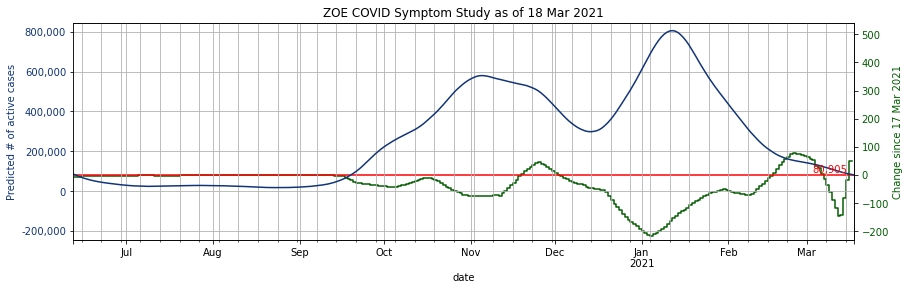

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

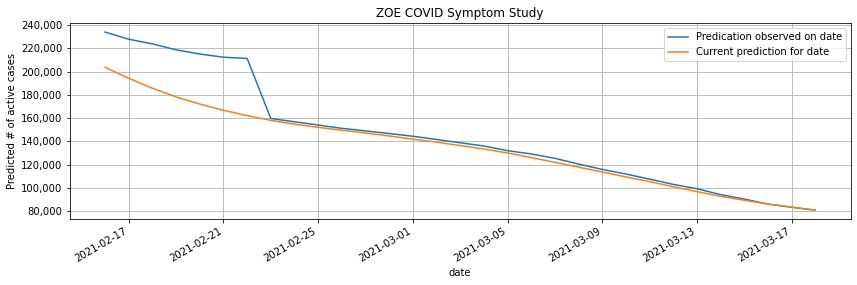

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-03-18_2021-03-18-16-39.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
373,North Ayrshire,S12000021,1.144889
328,Conwy,W06000003,0.990822
46,Northumberland,E06000057,0.698480
272,Tameside,E08000008,0.578874
177,Staffordshire Moorlands,E07000198,0.525403
308,Perth and Kinross,S12000024,0.518949
112,East Dorset,E07000049,0.514231
7,Halton,E06000006,0.501860
323,North Lanarkshire,S12000044,0.501350
261,Dudley,E08000027,0.496960
